<a href="https://colab.research.google.com/github/cs-iuu/word-sense-2025-fall-ai/blob/main/13.1.mongolian_wsi_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mongolian WSI Notebook

**Word-Sense Induction (WSI) demo for Mongolian**

**Target words:** зам, гэр, амар, сайн, хүн, нэг

This Colab-ready notebook trains a SentencePiece tokenizer (BPE) on your Mongolian Bible corpus, extracts contexts for selected target words, computes contextual embeddings with a multilingual SentenceTransformer, clusters contexts (HDBSCAN) to discover senses, visualizes the results (UMAP), and exports a JSON with induced sense examples.

---

**Instructions:** Upload your `mn_bible.txt` file when prompted. Each line should be a verse or sentence. If your file is large, Colab may take time to train the tokenizer; we keep sizes conservative by default.


In [1]:
# Install required libraries
!pip install -q sentencepiece sentence-transformers hdbscan umap-learn sklearn matplotlib seaborn

# show versions
import sentencepiece, sklearn, sentence_transformers
print("sentencepiece", sentencepiece.__version__)
print("sentence-transformers", sentence_transformers.__version__)
print("sklearn", sklearn.__version__)

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
sentencepiece 0.2.1
sentence-transformers 5.1.2
sklearn 1.6.1


In [2]:
# # Upload mn_bible.txt
# from google.colab import files
# uploaded = files.upload()
# if len(uploaded) == 0:
#     raise SystemExit("Please upload mn_bible.txt")
# filename = list(uploaded.keys())[0]
# print("Uploaded file:", filename)

file_path = "/content/Bible_NT.mn.txt"
# Read lines
with open(file_path, "r", encoding="utf-8") as f:
    lines = [l.strip() for l in f if l.strip()]
print(f"Loaded {len(lines)} non-empty lines")

Loaded 12544 non-empty lines


In [3]:
# Train SentencePiece BPE tokenizer on the corpus (small vocab to keep it fast)
import sentencepiece as spm
corpus_path = file_path
model_prefix = "mn_sp"
vocab_size = 8000

spm.SentencePieceTrainer.train(
    input=corpus_path,
    model_prefix=model_prefix,
    vocab_size=vocab_size,
    model_type="bpe",
    character_coverage=0.9995,
    bos_id=-1, eos_id=-1
)

print("Trained SentencePiece model:", model_prefix + ".model")

Trained SentencePiece model: mn_sp.model


In [4]:
# Load SentencePiece model and test tokenization
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load("mn_sp.model")

test_sent = lines[0] if len(lines)>0 else "Би сургуульд явж байна."
print("Example sentence:", test_sent)
print("SP tokens:", sp.encode(test_sent, out_type=str)[:50])

Example sentence: Абрахамын удам, Давидын удам, Есүс Христийн угийн бичиг.
SP tokens: ['▁Абрахамын', '▁удам', ',', '▁Давидын', '▁удам', ',', '▁Есүс', '▁Христийн', '▁угийн', '▁бичиг', '.']


In [5]:
# Define target words and extract context windows
targets = ["зам", "гэр", "амар", "сайн", "хүн", "амьдрал"]  # chosen target words
print("Targets:", targets)

window = 5  # context window size (words either side)
max_examples_per_word = 500  # cap to limit runtime

from collections import defaultdict
contexts = defaultdict(list)   # word -> list of context strings
occurrence_meta = defaultdict(list)  # store (line_id, line_text) pairs

for idx, line in enumerate(lines):
    toks = line.split()
    for i, tok in enumerate(toks):
        if tok in targets:
            start = max(0, i-window)
            end = min(len(toks), i+window+1)
            ctx = " ".join(toks[start:end])
            if len(contexts[tok]) < max_examples_per_word:
                contexts[tok].append(ctx)
                occurrence_meta[tok].append((idx, line))

# Show counts
for t in targets:
    print(f"{t}: {len(contexts[t])} contexts")

Targets: ['зам', 'гэр', 'амар', 'сайн', 'хүн', 'нэг']
зам: 18 contexts
гэр: 49 contexts
амар: 66 contexts
сайн: 291 contexts
хүн: 500 contexts
нэг: 434 contexts


In [6]:
# Load multilingual sentence-transformer and encode contexts
from sentence_transformers import SentenceTransformer
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
print("Loading model:", model_name)
smodel = SentenceTransformer(model_name)

# Prepare encoding
all_contexts = []
for w, ctxs in contexts.items():
    for c in ctxs:
        all_contexts.append(c)

print("Total contexts to encode:", len(all_contexts))
embs = smodel.encode(all_contexts, show_progress_bar=True, convert_to_numpy=True)

Loading model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Total contexts to encode: 1358


Batches:   0%|          | 0/43 [00:00<?, ?it/s]

In [7]:
# Cluster contexts per word using HDBSCAN
import numpy as np
import hdbscan

# We'll cluster each word's contexts separately and store labels
start_idx = 0
word_clusters = {}

for w in targets:
    n = len(contexts[w])
    if n == 0:
        word_clusters[w] = {"labels": [], "embeddings": None, "contexts": []}
        continue
    sub_embs = embs[start_idx:start_idx+n]
    start_idx += n

    # use HDBSCAN for unknown k; set min_cluster_size
    clusterer = hdbscan.HDBSCAN(min_cluster_size=max(3, min(10, n//10)), metric='euclidean')
    labels = clusterer.fit_predict(sub_embs)
    word_clusters[w] = {"labels": labels.tolist(), "embeddings": sub_embs.tolist(), "contexts": contexts[w]}
    print(f"{w}: clusters found (unique labels):", set(labels))

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skle

зам: clusters found (unique labels): {np.int64(-1)}
гэр: clusters found (unique labels): {np.int64(-1)}
амар: clusters found (unique labels): {np.int64(-1)}
сайн: clusters found (unique labels): {np.int64(-1)}
хүн: clusters found (unique labels): {np.int64(-1)}
нэг: clusters found (unique labels): {np.int64(-1)}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [8]:
# Function to show clusters for a given word
import numpy as np
from collections import defaultdict, Counter

def show_clusters(word, topk=5):
    data = word_clusters[word]
    labels = np.array(data['labels'])
    ctxs = data['contexts']
    if len(labels)==0:
        print("No contexts for", word); return
    unique = sorted(set(labels))
    for lbl in unique:
        if lbl == -1:
            print("\n-- Noise / unclustered --")
        else:
            print(f"\n== Sense cluster {lbl} ==")
        idxs = np.where(labels==lbl)[0]
        print(f"Count: {len(idxs)}")
        # show top representative contexts (first few)
        for i in idxs[:topk]:
            print(" -", ctxs[i])
        # show top words in these contexts
        words = []
        for i in idxs:
            words.extend(ctxs[i].split())
        c = Counter(words)
        print("Top context words:", c.most_common(10))

# Example: show clusters for all targets
for t in targets:
    print('\n' + '='*40)
    print('WORD:', t)
    show_clusters(t, topk=5)


WORD: зам

-- Noise / unclustered --
Count: 18
 - «Иорданы чанад тэнгис хүрэх зам дээрх Зебулуны болоод Нафталийн нутаг,
 - татан оруулдаг хаалга нь өргөн, зам нь
 - зам нь нарийн юм. Цөөхөн хүн
 - булаан авдаг байна. Энэ нь зам
 - хувцсаа зам дээр дэвсэхэд, зарим нь модноос
Top context words: [('зам', 18), ('нь', 10), ('дээр', 5), ('зарим', 3), ('хавиар', 3), ('юм.', 2), ('модноос', 2), ('Түүнийг', 2), ('Тэд', 2), ('«Иорданы', 1)]

WORD: гэр

-- Noise / unclustered --
Count: 49
 - Хүний дайсан нь өөрийнх нь гэр
 - хуваагдвал сүйрнэ. Аливаа хот, эсвэл гэр дотроо
 - болно. Миний нэрийн төлөө өөрийн гэр орноо, ах дүүсээ,
 - — "Миний гэр бол залбирлын гэр гэж нэрлэгдэх
 - — "Миний гэр бол залбирлын гэр гэж нэрлэгдэх болно" гэж бичигдсэн
Top context words: [('гэр', 57), ('нь', 11), ('гэж', 8), ('—', 7), ('бол', 6), ('залбирлын', 6), ('"Миний', 5), ('та', 5), ('Бурханы', 5), ('төлөө', 4)]

WORD: амар

-- Noise / unclustered --
Count: 66
 - тэр айл чинь зохистой бол, амар амгалангийн мэнд ч


Plotting: зам


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-1475014946.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique))


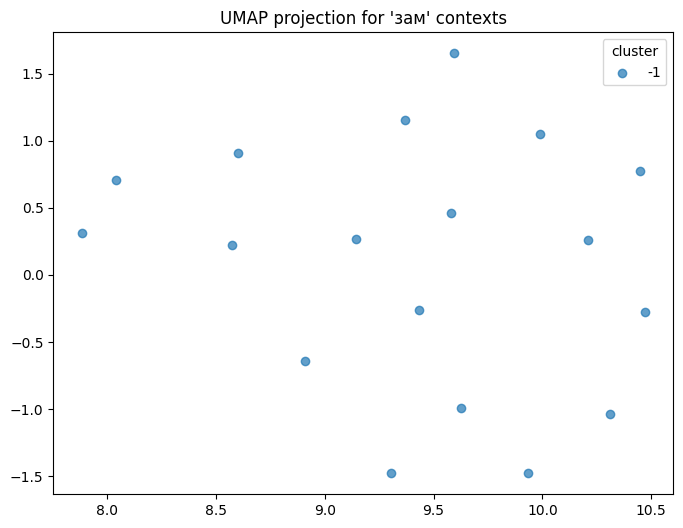

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Plotting: гэр


/tmp/ipython-input-1475014946.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique))


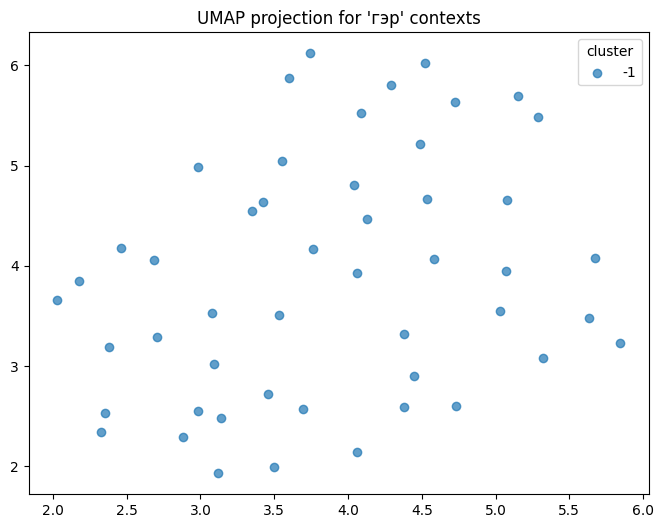


Plotting: амар


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-1475014946.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique))


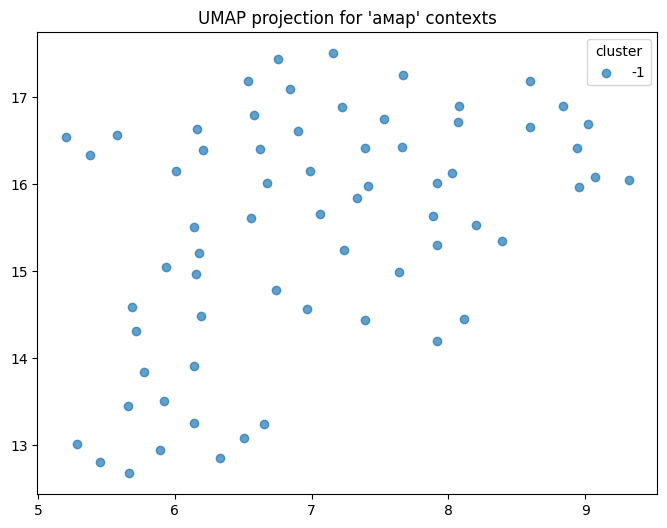

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Plotting: сайн


/tmp/ipython-input-1475014946.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique))


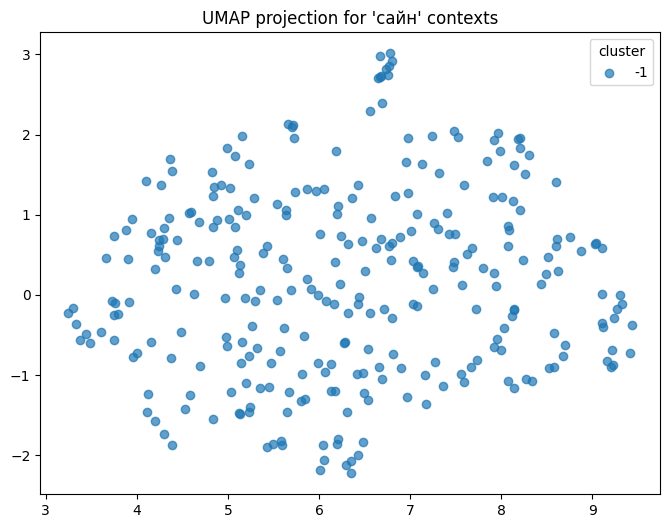

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Plotting: хүн


/tmp/ipython-input-1475014946.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique))


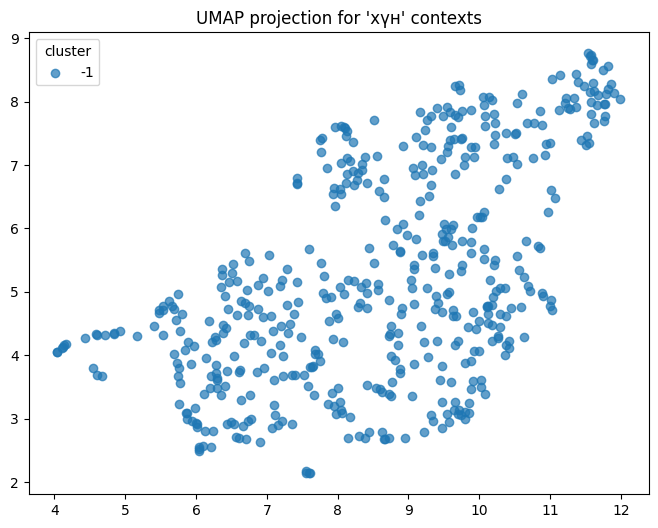

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Plotting: нэг


/tmp/ipython-input-1475014946.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique))


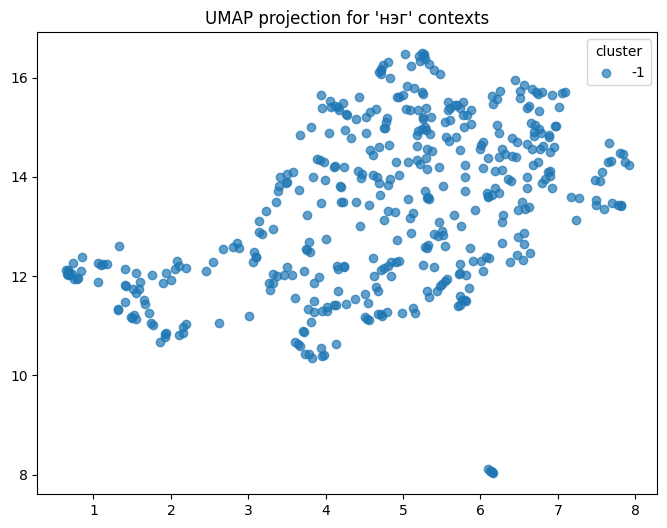

In [9]:
# Visualize cluster embeddings for a chosen word using UMAP
import umap
import matplotlib.pyplot as plt
import numpy as np

def plot_word_umap(word):
    data = word_clusters[word]
    labels = np.array(data['labels'])
    em = np.array(data['embeddings'])
    if em.size == 0:
        print("No data")
        return
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
    red = reducer.fit_transform(em)
    plt.figure(figsize=(8,6))
    unique = sorted(set(labels))
    palette = plt.cm.get_cmap('tab10', len(unique))
    for i, lbl in enumerate(unique):
        mask = (labels==lbl)
        plt.scatter(red[mask,0], red[mask,1], label=str(lbl), alpha=0.7)
    plt.legend(title='cluster')
    plt.title(f"UMAP projection for '{word}' contexts")
    plt.show()

# Plot for each target (first few)
for t in targets:
    try:
        print("\nPlotting:", t)
        plot_word_umap(t)
    except Exception as e:
        print("Plot error for", t, e)

In [10]:
# Save induced senses to JSON for inspection or later use
import json
out = {}
for w in targets:
    data = word_clusters[w]
    labels = data['labels']
    ctxs = data['contexts']
    clusters = {}
    for lbl in sorted(set(labels)):
        inds = [i for i, lab in enumerate(labels) if lab==lbl]
        clusters[str(lbl)] = {
            "count": len(inds),
            "examples": [ctxs[i] for i in inds[:10]]
        }
    out[w] = clusters

with open("mn_wsi_results.json", "w", encoding="utf-8") as f:
    json.dump(out, f, ensure_ascii=False, indent=2)

print('Saved mn_wsi_results.json')

Saved mn_wsi_results.json


## Next steps and discussion

- Inspect `mn_wsi_results.json` to read sense clusters and examples.
- You can refine clustering hyperparameters (min_cluster_size), window size, and max_examples_per_word.
- For publication-level work, add evaluation (human annotation), compare models (XLM-R, Mongolian FastText), and try substitution-based WSI.

### Exercises for students
1. Change `num_examples_per_word` cap and observe changes.
2. Try replacing SentenceTransformer model with `paraphrase-multilingual-mpnet-base-v2`.
3. Implement aggregation of subword tokens into word-level analysis if needed.
